# UIDAI Data Hackathon 2026  
## Notebook 06: Aadhaar Service Stress & Anomaly Detection Model

This notebook implements a working, explainable analytical model that
identifies districts experiencing high Aadhaar service stress based on
enrolment, biometric updates, and demographic updates.

The model converts analytical insights into an actionable decision-support
framework for UIDAI.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
BASE_PATH = "/Users/aaronrao/Desktop/projects/UIDAI_Aadhaar_Data_Insights/data/processed"

biometric_df = pd.read_csv(os.path.join(BASE_PATH, "biometric_cleaned.csv"))
demographic_df = pd.read_csv(os.path.join(BASE_PATH, "demographic_cleaned.csv"))
enrolment_df = pd.read_csv(os.path.join(BASE_PATH, "enrolment_cleaned.csv"))

/var/folders/qs/5q2_h5j931g_w8krqy_fjh640000gn/T/ipykernel_58758/3433212929.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  biometric_df = pd.read_csv(os.path.join(BASE_PATH, "biometric_cleaned.csv"))
/var/folders/qs/5q2_h5j931g_w8krqy_fjh640000gn/T/ipykernel_58758/3433212929.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  demographic_df = pd.read_csv(os.path.join(BASE_PATH, "demographic_cleaned.csv"))
/var/folders/qs/5q2_h5j931g_w8krqy_fjh640000gn/T/ipykernel_58758/3433212929.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  enrolment_df = pd.read_csv(os.path.join(BASE_PATH, "enrolment_cleaned.csv"))


In [3]:
bio_district = biometric_df.groupby(
    ["state", "district"], as_index=False
)["total_biometric_updates"].sum()

demo_district = demographic_df.groupby(
    ["state", "district"], as_index=False
)["total_demographic_updates"].sum()

enrol_district = enrolment_df.groupby(
    ["state", "district"], as_index=False
)["total_enrolments"].sum()

In [4]:
model_df = enrol_district.merge(
    bio_district, on=["state", "district"], how="left"
).merge(
    demo_district, on=["state", "district"], how="left"
)

model_df.fillna(0, inplace=True)
model_df.head()

,state,district,total_enrolments,total_biometric_updates,total_demographic_updates
0,100000,100000,218.0,0.0,2.0
1,Andaman & Nicobar Islands,Andamans,75.0,2015.0,750.0
2,Andaman & Nicobar Islands,Nicobars,1.0,2.0,4.0
3,Andaman & Nicobar Islands,South Andaman,38.0,367.0,305.0
4,Andaman And Nicobar Islands,Nicobar,75.0,1811.0,787.0


In [5]:
# Avoid division by zero
model_df["biometric_update_ratio"] = np.where(
    model_df["total_enrolments"] > 0,
    model_df["total_biometric_updates"] / model_df["total_enrolments"],
    0
)

model_df["demographic_update_ratio"] = np.where(
    model_df["total_enrolments"] > 0,
    model_df["total_demographic_updates"] / model_df["total_enrolments"],
    0
)

In [6]:
model_df["service_stress_score"] = (
    0.5 * model_df["biometric_update_ratio"] +
    0.5 * model_df["demographic_update_ratio"]
)

In [7]:
def classify_stress(score):
    if score < 0.2:
        return "Low (Stable Region)"
    elif score < 0.5:
        return "Medium (Moderate Mobility)"
    elif score < 1.0:
        return "High (Service Stress)"
    else:
        return "Very High (Priority Intervention)"

model_df["stress_category"] = model_df["service_stress_score"].apply(classify_stress)

In [8]:
model_df.sort_values(
    by="service_stress_score", ascending=False
).head(10)

,state,district,total_enrolments,total_biometric_updates,total_demographic_updates,biometric_update_ratio,demographic_update_ratio,service_stress_score,stress_category
855,Telangana,Medchal?Malkajgiri,2.0,856.0,350.0,428.000000,175.000000,301.500000,Very High (Priority Intervention)
743,Rajasthan,Beawar,1.0,8.0,510.0,8.000000,510.000000,259.000000,Very High (Priority Intervention)
739,Rajasthan,Balotra,1.0,6.0,503.0,6.000000,503.000000,254.500000,Very High (Priority Intervention)
755,Rajasthan,Didwana-Kuchaman,2.0,8.0,720.0,4.000000,360.000000,182.000000,Very High (Priority Intervention)
773,Rajasthan,Salumbar,1.0,1.0,213.0,1.000000,213.000000,107.000000,Very High (Priority Intervention)
211,Daman & Diu,Daman,9.0,1412.0,377.0,156.888889,41.888889,99.388889,Very High (Priority Intervention)
519,Maharashtra,Ahilyanagar,13.0,17.0,2418.0,1.307692,186.000000,93.653846,Very High (Priority Intervention)
582,Manipur,Thoubal,1067.0,56043.0,59244.0,52.523899,55.523899,54.023899,Very High (Priority Intervention)
575,Manipur,Imphal East,1132.0,59274.0,56020.0,52.362191,49.487633,50.924912,Very High (Priority Intervention)
609,Mizoram,Serchhip,102.0,7604.0,2455.0,74.549020,24.068627,49.308824,Very High (Priority Intervention)


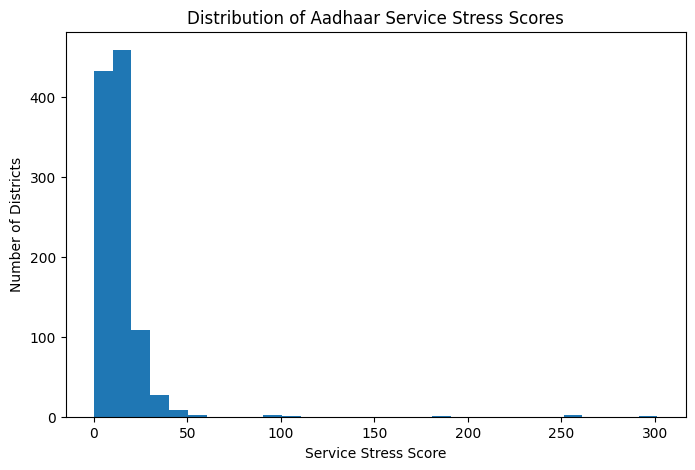

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(model_df["service_stress_score"], bins=30)
plt.title("Distribution of Aadhaar Service Stress Scores")
plt.xlabel("Service Stress Score")
plt.ylabel("Number of Districts")
plt.show()

In [10]:
OUTPUT_PATH = "/Users/aaronrao/Desktop/projects/UIDAI_Aadhaar_Data_Insights/outputs/tables"
os.makedirs(OUTPUT_PATH, exist_ok=True)

model_df.to_csv(
    os.path.join(OUTPUT_PATH, "aadhaar_service_stress_model_output.csv"),
    index=False
)

print("Model output saved successfully.")

Model output saved successfully.


### Model Summary
- Developed an explainable analytical model to assess Aadhaar service stress
- Normalized update activity using enrolment-based ratios
- Classified districts into actionable priority categories
- Output can support targeted interventions, staffing, and infrastructure planning

This model demonstrates how analytical insights can be translated into
a practical decision-support framework for UIDAI.